# Under- and overfitting, model selection

## Preliminaries

In the first set of exercises you had to implement the training and evaluation of the linear regression and $k$-NN methods from scratch in order to practice your `numpy` skills. From this set of exercises onward, you can use the implementations provided in `scikit-learn` or other higher-level libraries. We start this set of exercises by demonstrating some of the features of `scikit-learn`.

For example, implementation of linear regression model fitting with an analytical solution for the parameters is provided by the class `sklearn.linar_model.LinearRegression`. You can train a linear regression model in the following way:

In [2]:
import numpy as np
from sklearn import datasets, linear_model

# load the diabetes dataset
diabetes = datasets.load_diabetes()

# use only one feature
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

# split the data into training/testing sets
X_train = X[:-20]
X_test = X[-20:]

# split the targets into training/testing sets
y_train = y[:-20]
y_test = y[-20:]

# create linear regression object
model = linear_model.LinearRegression()

# train the model using the training dataset
model.fit(X_train, y_train)

LinearRegression()

Let's visualize the training dataset and the learned regression model.

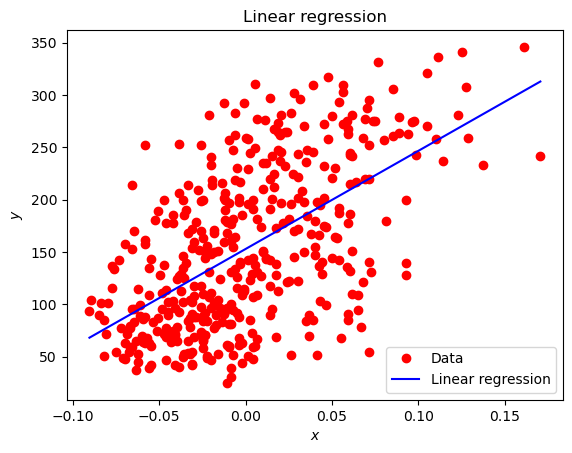

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(X_train, y_train, 'r.', markersize=12)
X_edge = np.array([np.min(X_train, 0), np.max(X_train, 0)])
plt.plot(X_edge, model.predict(X_edge), 'b-')
plt.legend(('Data', 'Linear regression'), loc='lower right')
plt.title('Linear regression')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Once trained, the model can be used to make predictions on the test data:

In [4]:
# Make predictions using the testing dataset
prediction = model.predict(X_test)

The next step (not shown here) is to evaluate the performance of the trained model.

Note that the `scikit-learn` interface works by first initializing an object from the class that implements the machine learning model (linear regression in this case) and then fitting the initialized model using the data in the training set. Finally, the trained (fitted) model can be used to make predictions on unseen data. In fact, all models implemented in this library follow the same *initialize-fit-predict* programming interface. For example, a $k$-NN classifier can be trained in the following way:

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# make use of the train_test_split() utility function instead
# of manually dividing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

# initialize a 3-NN classifier
model = neighbors.KNeighborsClassifier(n_neighbors=3)

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)

Note that the features in the breast cancer dataset have different scales (some have on average very small absolute values, and some very large), which means that the distance metric used by $k$-NN will me dominated by the features with large values. You can use any of the number of feature transformation methods implemented in `scikit-learn` to scale the features. For example, you can use the `sklearn.preprocessing.StandardScaler` method to transform all features to a have a zero mean and unit variance:

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

The scaler has its own parameters which are the means and standard deviations of the features estimated from the training set. If you train a model with the scaled features, you will have to remember to also apply the scaling transformation every time you make a prediction on new unseen and unscaled data. This is somewhat prone to error. One option for making the code more robust is to create a processing pipeline that includes the scaling and $k$-NN models in a sequence:

In [7]:
from sklearn.pipeline import Pipeline

knn = neighbors.KNeighborsClassifier(n_neighbors=3)

model = Pipeline([
                 ("scaler", scaler),
                 ("knn", knn)
                ])

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)


If you are curious, more information about the design of the `scikit-learn` application programming interface (API) can be found [in this paper](https://arxiv.org/pdf/1309.0238.pdf). 

## Exercises

### Bias-variance decomposition

Show that the mean squared error of the estimate of a parameter can be decomposed into an expression that includes both the bias and variance (Eq. 5.53-5.54 in "Deep learning" by Goodfellow et al.). 

Definition of MSE: MSE = E[$(\hat{\theta_n} - \theta)^2$] 

$(\hat{\theta_n} - \theta)^2$ can be rewritten according to:

$(\hat{\theta_n} - \theta)^2$ = $(\hat{\theta_n} - E[\hat{\theta_n}] + E[\hat{\theta_n}] - \theta)^2$ = $((\hat{\theta_n} - E[\hat{\theta_n}]) + (E[\hat{\theta_n}] - \theta))^2$

This can be worked out to:

$((\hat{\theta_n} - E[\hat{\theta_n}]) + (E[\hat{\theta_n}] - \theta))^2$ = $(\hat{\theta_n} - E[\hat{\theta_n}])^2 + 2(\hat{\theta_n} - E[\hat{\theta_n}])(E[\hat{\theta_n}] - \theta) + (E[\hat{\theta_n}] - \theta)^2$

Therefore:

MSE = E[$(\hat{\theta_n} - \theta)^2$] = E[$(\hat{\theta_n} - E[\hat{\theta_n}])^2] + 2E[(\hat{\theta_n} - E[\hat{\theta_n}])(E[\hat{\theta_n}] - \theta)] + E[(E[\hat{\theta_n}] - \theta)^2]$

Since the expected deviation from the mean is zero (for samples from a random variable the expected value is equal to their mean): $\hat{\theta_n} - E[\hat{\theta_n}] = 0$. So the second term disappears and we're left with:

MSE = E[$(\hat{\theta_n} - E[\hat{\theta_n}])^2] + E[(E[\hat{\theta_n}] - \theta)^2$] = $Var(\hat{\theta_n}) + Bias(\hat{\theta_n})^2$

With $Var(\hat{\theta_n}) = (\hat{\theta_n} - E[\hat{\theta_n}])^2$

and $Bias(\hat{\theta_n}) = E[\hat{\theta_n}] - \theta$



### Polynomial regression

For this exercise we will be using generated data to better show the effects of the different polynomial orders.
The data is created using the make_polynomial_regression function.

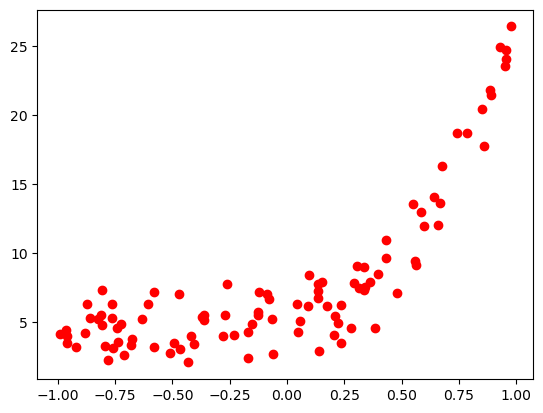

In [8]:
%matplotlib inline

def generate_dataset(n=100, degree=1, noise=1, factors=None):
    # Generates a dataset by adding random noise to a randomly
    # generated polynomial function.
    
    x = np.random.uniform(low=-1, high=1, size=n)
    
    factors = np.random.uniform(0, 10, degree+1)
    
    y = np.zeros(x.shape)
    
    for idx in range(degree+1):
        y += factors[idx] * (x ** idx)

    # add noise
    y += np.random.normal(-noise, noise, n)
    
    return x, y

# load generated data
np.random.seed(0)

X, y = generate_dataset(n=100, degree=4, noise=1.5)

plt.plot(X, y, 'r.', markersize=12)

Implement polynomial regression using the `sklearn.preprocessing.PolynomialFeatures` transformation. Using the `sklearn.grid_search.GridSearchCV` class, perform a grid search of the polynomial order hyperparameter space with cross-validation and report the performance on an independent test set.


Plot a learning curve that show the validation accuracy as a function of the polynomial order. 

Best degree is 4 with MSE = 9.1 +/- 7.1


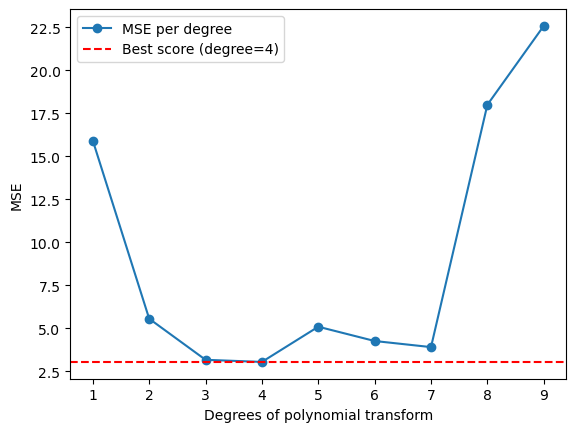

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

np.random.seed(0)
X, y = generate_dataset(n=100, degree=4, noise=1.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40)

polynomial_features = PolynomialFeatures(include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])

degrees = 9
cv_folds = 4
search = GridSearchCV(
    estimator=pipeline,
    param_grid={'polynomial_features__degree': range(1,degrees+1)},
    scoring='neg_mean_squared_error',
    cv=cv_folds,
)

search.fit(X_train[:, np.newaxis], y_train)
mse_scores = -search.cv_results_['mean_test_score']
best_degree = np.argmin(mse_scores) + 1
print(f"Best degree is {best_degree} with MSE = {mse_scores.mean():.2} +/- {mse_scores.std():.2}")

plt.plot(range(1,degrees+1), mse_scores, marker="o", label="MSE per degree")
plt.axhline(y=min(mse_scores), color='r', linestyle='--', label=f"Best score (degree={best_degree})")
plt.xlabel("Degrees of polynomial transform")
plt.ylabel("MSE")
plt.legend()
plt.show()

On an independent test set the result is the following.

In [10]:
from sklearn.model_selection import cross_val_score

polynomial_features = PolynomialFeatures(degree=best_degree, include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train[:, np.newaxis], y_train)

# Evaluate the models using crossvalidation
cv_folds = 4  # cross validation folds
scores = cross_val_score(pipeline, X_test[:, np.newaxis], y_test, scoring="neg_mean_squared_error", cv=cv_folds)
print(f"MSE = {-scores.mean():.2} +/- {scores.std():.2}")

MSE = 2.1 +/- 1.2



<p><font color='#770a0a'>Which models have a high bias, and which models have high variance? Motivate your answer.</font><p>

The error due to bias is taken as the difference between the expected (or average) prediction of a model and the correct value which is attempted to be predicted. While the error due to variance is taken as the variability of a model's prediction for a given data point. These terms are most applicable when thinking about rebuilding different models by repeatedly sampling new data. Due to noise, you may end up with a slightly different model. The bias for particular prediction corresponds to the difference between its expected value and its true value. The variance corresponds to the spread of these predictions. 
There is a tradeoff between these errors. As you tweak model parameters (degree of polynomial in this case) and try to decrease one, it will lead to an increase in the other, and vice versa. You can observe the bias-variance tradeoff by observing different fits for the same dataset. You get quite different fit for a higher degree polynomial (high variance) while you get the same model for a low degree polynomial (low variance). On the other hand, a high degree polynomial closely fits more number of points, hence the bias is low. While a low degree polynomial does not have this expressivity leading to high bias.


    
Repeat this experiment, this time using the diabetes dataset instead of the generated data.

Best degree is 3 with MSE = 4.34e+03 +/- 5.04e+02


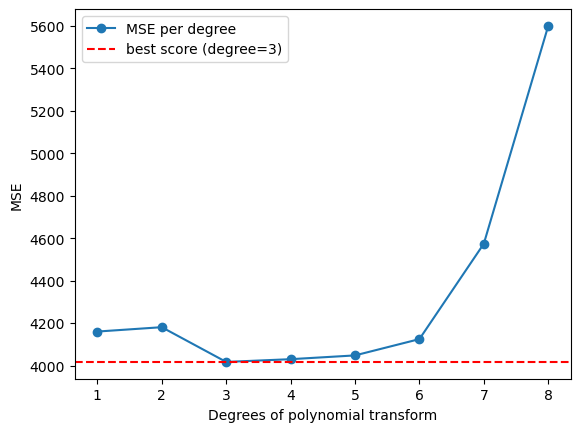

In [11]:
from sklearn import datasets

# load the diabetes dataset
diabetes = datasets.load_diabetes()

# use only one feature
X = diabetes.data[:, np.newaxis, 8]
y = diabetes.target

# split the data into training/testing sets
X_train = X[:-20]
X_test = X[-20:]

# split the targets into training/testing sets
y_train = y[:-20]
y_test = y[-20:]

polynomial_features = PolynomialFeatures(include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])

degrees = 8
cv_folds = 4
search = GridSearchCV(
    estimator=pipeline,
    param_grid={'polynomial_features__degree': range(1, degrees+1)},
    scoring='neg_mean_squared_error',
    cv=cv_folds,
)

search.fit(X_train, y_train)
mse_scores = -search.cv_results_['mean_test_score']
best_degree = np.argmin(mse_scores) + 1
print(f"Best degree is {best_degree} with MSE = {mse_scores.mean():.2e} +/- {mse_scores.std():.2e}")

plt.plot(range(1, degrees+1), mse_scores, marker="o", label="MSE per degree")
plt.axhline(y=min(mse_scores), color='r', linestyle='--', label=f"best score (degree={np.argmin(mse_scores)+1})")
plt.xlabel("Degrees of polynomial transform")
plt.ylabel("MSE")
plt.legend()
plt.show()

On an independent test set the result is the following.

In [12]:
polynomial_features = PolynomialFeatures(degree=best_degree, include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train)

# Evaluate the model using crossvalidation
cv_folds = 4  # cross validation folds
scores = cross_val_score(pipeline, X_test, y_test, scoring="neg_mean_squared_error", cv=cv_folds)
print(f"MSE = {-scores.mean():.2} +/- {scores.std():.2}")

MSE = 2.3e+03 +/- 4.1e+02


### ROC curve analysis
A common method to evaluate binary classifiers is the receiver operating characteristic (ROC) curve. Similar to the week one practicals, implement a $k$-NN classifier on the breast cancer dataset, however, his time use the $k$-NN pipeline from the preliminary. Train the model for different values of $k$ and evaluate their respective performance with an ROC curve, use the `sklearn.metrics.roc_curve` function.

C:\Users\20202619\AppData\Local\Temp\ipykernel_1548\890931242.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', max_k)
C:\Users\20202619\AppData\Local\Temp\ipykernel_1548\890931242.py:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(cmap=cmap,norm=norm),label='k value')


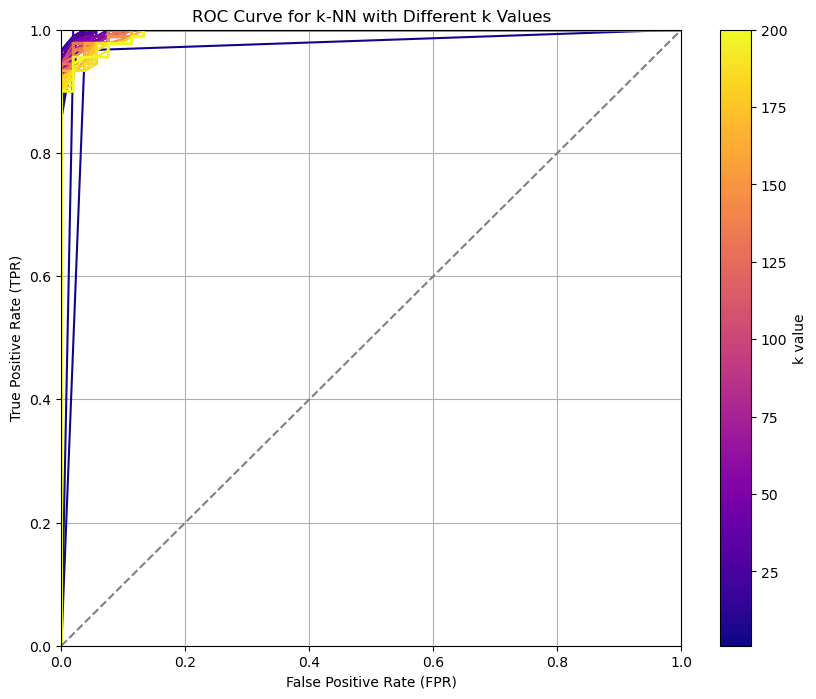

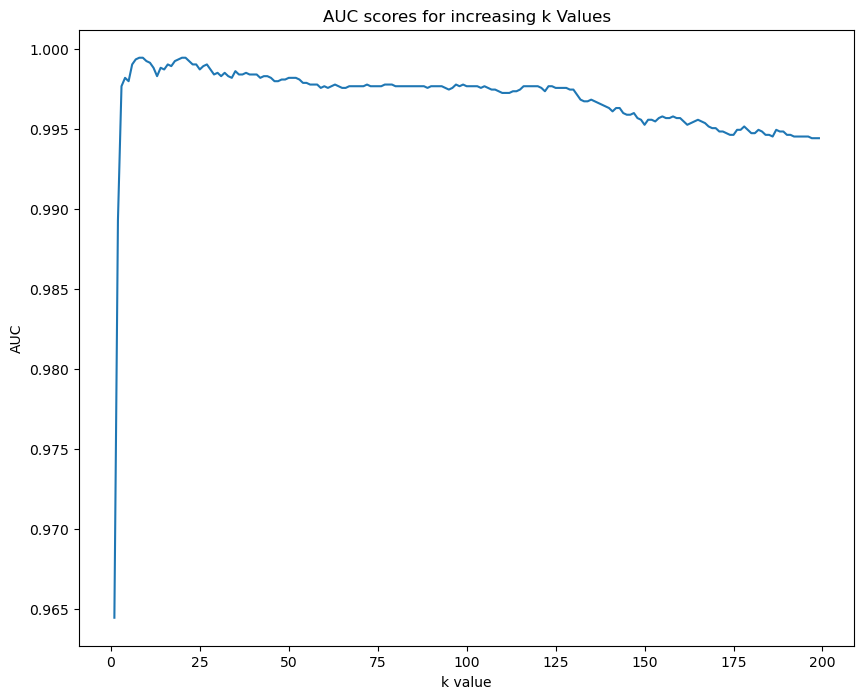

In [13]:
from sklearn import metrics
from matplotlib import cm
from matplotlib import colors

breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# make use of the train_test_split() utility function instead
# of manually dividing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

# Set parameters for exercise
max_k = 200 # len(y_train) gives an interesting plot too!

# Prepare plotting
plt.figure(figsize=(10, 8))
cmap = cm.get_cmap('plasma', max_k)
norm = colors.Normalize(vmin=1,vmax=max_k)
aucs = []
for k in range(1,max_k):
    # change k
    model.set_params(knn__n_neighbors=k)

    # train the model using the training dataset
    model.fit(X_train, y_train)

    # make predictions using the testing dataset
    prediction = model.predict_proba(X_test)[:, 1]

    # make ROC curve per k
    fpr, tpr, _ = metrics.roc_curve(y_test,prediction)
    aucs.append(metrics.auc(fpr, tpr))

    plt.plot(fpr, tpr, color=cmap(k))

# customize ROC plot
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for k-NN with Different k Values')
plt.colorbar(cm.ScalarMappable(cmap=cmap,norm=norm),label='k value') 
plt.grid(True)
plt.show()
    
# Make another plot showing AUC progression with increasing k
plt.figure(figsize=(10,8))
plt.plot(range(1,max_k),aucs)
plt.xlabel('k value')
plt.ylabel('AUC')
plt.title('AUC scores for increasing k Values')
plt.show();

### $F_1$ score and Dice similarity coefficient

The Dice similarity coefficient is a very popular evaluation measure for image segmentation applications. Assuming that $A$ is the ground truth segmentation of an object represented as a binary image, and $B$ is the binary output of an image segmentation method, the Dice similarity coefficient is computed as:

$\text{Dice}(A,B) = \frac{2|A\cap B|}{|A| + |B|}$

where $|\cdot|$ represents the cardinality of the objects (e.g. $|A|$ is the number of non-zero pixels in the ground truth segmentation).

For example, the Dice similarity can be computed in the following way:

0.3402777777777778


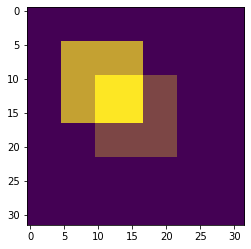

In [10]:
# generate some test objecys
A = np.zeros((32, 32))
A[10:-10, 10:-10] = 1
B = np.zeros((32, 32))
B[5:-15, 5:-15] = 1

dice = 2*np.sum(A*B)/(np.sum(A)+np.sum(B))

# display the results
plt.plot()
plt.imshow(A)
plt.imshow(B, alpha=0.7)

print(dice)

<p><font color='#770a0a'>Show that the $F_1$ score, which is the harmonic mean of precision and recall, is equivalent to the Dice similarity coefficient</font><p>

In [11]:
#Make matrix of summed values of both images
summed = A+B

#If the values are equal to 2, it was 1 on both images. So true positive
TP = np.count_nonzero(summed == 2)

#All of the other 1 values of image B are false positive
FP = np.count_nonzero(B == 1) - TP

#All of the 1 values of image A that aren't contained in the TP metric are false negatives
FN = np.count_nonzero(A == 1) - TP

#Calculate the F1 score
F_1 = 2*TP/(2*TP+FP+FN)

print("F1 score:", F_1)
print("Dice score:", dice)

if F_1 == dice:
    print("The F1 and dice scores are equal")
else:
    print("That shouldn't happen :(")


F1 score: 0.3402777777777778
Dice score: 0.3402777777777778
The F1 and dice scores are equal
